<a href="https://colab.research.google.com/github/aquibjaved/Bits_and_Pieces_DL/blob/main/Simple_BitLinear_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !python -m pip install lightning
! pip install bitnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 18.5 MB/s eta 0:00:00


In [19]:
import torch.nn.functional as F
from torch.optim import Adam
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor, nn

In [2]:
# https://github.com/kyegomez/BitNet/blob/main/bitnet/bitbnet_b158.py#L85

class BitLinear(nn.Linear):
    """
    BitLinear is a custom linear layer that performs binarization of weights and quantization of activations
    in a group-wise manner.

    Args:
        in_features (int): Number of input features.
        out_features (int): Number of output features.
        bias (bool, optional): If set to False, the layer will not learn an additive bias. Default is True.
        num_groups (int, optional): Number of groups to divide the weights and activations into. Default is 1.
    """

    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        num_groups: int = 1,
    ):
        super().__init__(in_features, out_features, bias)
        self.num_groups = num_groups
        self.eps = 1e-5
        self.norm = nn.LayerNorm(in_features)

    def ste(self, x):
        """
        Applies the sign function for binarization and uses Straight-Through Estimator (STE) during backward pass.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Binarized tensor.
        """
        binarized_x = torch.sign(x)
        binarized_x = (binarized_x - x).detach() + x
        return binarized_x

    def binarize_weights_groupwise(self):
        """
        Binarizes the weights of the layer in a group-wise manner using STE.

        Returns:
            Tensor: Binarized weights tensor.
        """
        group_size = self.weight.shape[0] // self.num_groups
        binarized_weights = torch.zeros_like(self.weight)

        for g in range(self.num_groups):
            start_idx = g * group_size
            end_idx = (g + 1) * group_size
            weight_group = self.weight[start_idx:end_idx]

            alpha_g = weight_group.mean()
            binarized_weights[start_idx:end_idx] = self.ste(weight_group - alpha_g)

        return binarized_weights

    def quantize_activations_groupwise(self, x, b=8):
        """
        Quantizes the activations of the layer in a group-wise manner.

        Args:
            x (Tensor): Input tensor.
            b (int, optional): Number of bits for quantization. Default is 8.

        Returns:
            Tensor: Quantized activations tensor.
        """
        Q_b = 2 ** (b - 1)

        group_size = x.shape[0] // self.num_groups
        quantized_x = torch.zeros_like(x)

        for g in range(self.num_groups):
            start_idx = g * group_size
            end_idx = (g + 1) * group_size
            activation_group = x[start_idx:end_idx]

            gamma_g = activation_group.abs().max()
            quantized_x[start_idx:end_idx] = torch.clamp(
                activation_group * Q_b / (gamma_g + self.eps),
                -Q_b + self.eps,
                Q_b - self.eps,
            )

        return quantized_x

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass of the BitLinear layer.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Output tensor.
        """
        # Normalize input
        x = self.norm(x)

        # Binarize weights and quantize activations
        binarized_weights = self.binarize_weights_groupwise()

        # Perform linear transformation
        output = torch.nn.functional.linear(x, binarized_weights, self.bias)

        # Quantize activations
        output = self.quantize_activations_groupwise(output)

        # Return output
        return output

import torch
import torch.nn.functional as F
from torch import Tensor, nn


def absmax_quantize(x: Tensor, bits: int = 8):
    """
    Absmax Quantization

    Args:
        x (torch.Tensor): Input tensor
        bits (int, optional): Number of bits. Defaults to 8.

    """
    Qb = 2 ** (bits - 1) - 1
    scale = Qb / torch.max(torch.abs(x))
    quant = (scale * x).round()
    dequant = quant / scale
    return quant.to(torch.int8), dequant


class BitLinear15b(nn.Module):
    """
    BitLinear implements a fully connected layer with ternary weight quantization.
    Weights are quantized to -1, 0, or +1 using an absmean quantization approach.
    """

    def __init__(self, in_features, out_features, bias):
        """
        Initializes the BitLinear layer.

        Args:
            in_features (int): Number of input features.
            out_features (int): Number of output features.
        """
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        self.eps = 1e-6  # Small epsilon for numerical stability

    def forward(self, x):
        """
        Forward pass through the BitLinear layer.

        Args:
            x (Tensor): Input tensor of shape (..., in_features).

        Returns:
            Tensor: Output tensor of shape (..., out_features).
        """
        x = torch.sign(x)
        quantized_weight = self.quantize_weights(self.weight)
        return F.linear(x, quantized_weight)
        # return x

    def quantize_weights(self, W):
        """
        Quantizes the weights using the absmean quantization function.

        Args:
            W (Tensor): The weight tensor to be quantized.

        Returns:
            Tensor: Quantized weight tensor.
        """
        gamma = torch.mean(torch.abs(W)) + self.eps
        W_scaled = W / gamma
        W_quantized = torch.sign(W_scaled) * torch.clamp(
            torch.abs(W_scaled).round(), max=1.0
        )
        return W_quantized

    def extra_repr(self):
        """
        Provides additional information for debugging and logging.
        """
        return "in_features={}, out_features={}, quantization=ternary".format(
            self.in_features, self.out_features
        )


# # Initialize the BitLinear layer
# bit_linear = BitLinear15b(in_features=128, out_features=64)
# # Example input tensor
# x = torch.randn(10, 128)  # Example input
# output = bit_linear(x)  # Forward pass
# print(output)

In [3]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Load the dataset
dataset = datasets.MNIST(os.getcwd(), download=True, transform=transforms.ToTensor())

# Split dataset into training and testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader for training data
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Optionally, create DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 78184663.55it/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 26997034.51it/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22927709.60it/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13695563.46it/s]


Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [13]:
from tqdm import tqdm
import matplotlib.pyplot as plt

Epoch 1/1: 100%|██████████| 750/750 [00:24<00:00, 31.01it/s, loss=0.134]


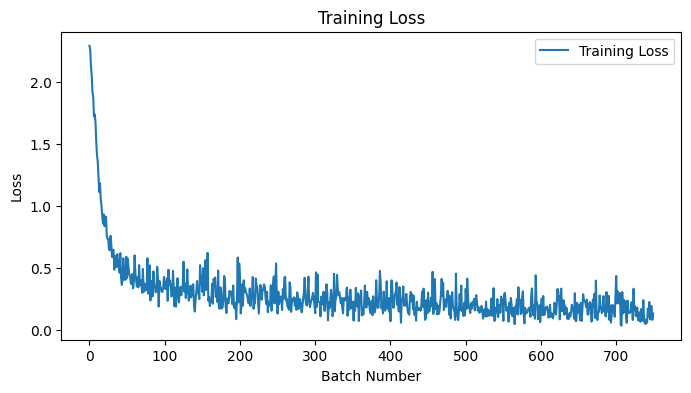

In [14]:
model = SimpleNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss()
num_epochs = 1

losses = []  # To store loss values

model.train()  # Set the model to training mode
for epoch in range(num_epochs):
    with tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as t:
        for batch_idx, (data, target) in t:
            optimizer.zero_grad()  # Zero the gradients
            output = model(data)  # Forward pass
            loss = criterion(output, target)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update parameters

            losses.append(loss.item())  # Append the loss

            # Optionally, update the tqdm bar with the current loss value
            t.set_postfix(loss=loss.item())

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
def predict(model, data_loader):
    model.eval() # Set the model to evaluation mode
    true_labels = []
    predictions = []

    with torch.no_grad():
        for data, labels in test_loader:
            output = model(data.view(data.size(0), -1))
            _, preds = torch.max(output, 1)
            true_labels.extend(labels.numpy())
            predictions.extend(preds.numpy())

    return true_labels, predictions

# Assuming you have a DataLoader for your test data: test_loader
true_labels, predictions  = predict(model, test_loader)


Accuracy: 0.9570
Precision: 0.9572
Recall: 0.9565
F1 Score: 0.9567


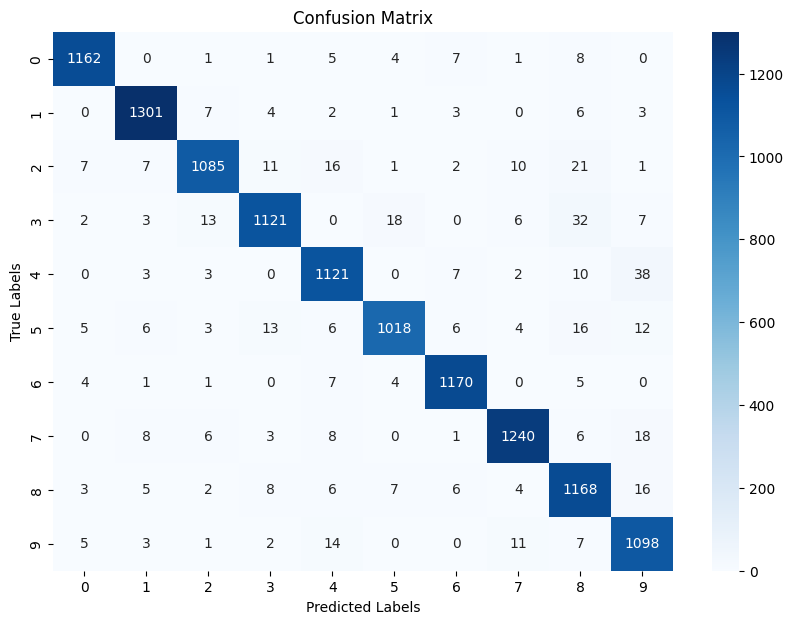

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_performance_metrics(true_labels, predictions, average='macro'):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average=average)
    recall = recall_score(true_labels, predictions, average=average)
    f1 = f1_score(true_labels, predictions, average=average)
    conf_matrix = confusion_matrix(true_labels, predictions)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# After your model has made predictions:
calculate_performance_metrics(true_labels, predictions)


In [20]:
for name, param in model.named_parameters():
    if 'weight' in name:
        print(f"{name}: {param.data}")

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

# Calculate model size in MB
model_size = params * 4 / (1024 * 1024)  # Since each parameter is a 32-bit float, hence 4 bytes

print(f"Model size: {model_size:.2f} MB")

fc1.weight: tensor([[ 0.0317,  0.0172, -0.0242,  ..., -0.0260, -0.0204,  0.0056],
        [ 0.0081, -0.0084, -0.0046,  ...,  0.0039, -0.0143, -0.0348],
        [-0.0017,  0.0067, -0.0107,  ..., -0.0308, -0.0352, -0.0287],
        ...,
        [-0.0140,  0.0097, -0.0306,  ...,  0.0228,  0.0171,  0.0147],
        [-0.0299, -0.0184, -0.0234,  ...,  0.0266, -0.0176, -0.0268],
        [-0.0347, -0.0125,  0.0233,  ..., -0.0057,  0.0006,  0.0011]])
fc2.weight: tensor([[ 0.0650,  0.0589, -0.0483,  ...,  0.0371,  0.0355,  0.0161],
        [-0.0855,  0.0013, -0.0432,  ..., -0.0384, -0.0447, -0.0752],
        [ 0.0208,  0.0574,  0.0360,  ...,  0.0314,  0.0423, -0.0511],
        ...,
        [-0.0977, -0.0526,  0.0707,  ..., -0.0663,  0.0273, -0.0409],
        [ 0.0224, -0.0692, -0.0438,  ...,  0.0013, -0.0125, -0.0002],
        [-0.0053, -0.0662,  0.0480,  ...,  0.0677,  0.0652,  0.0495]])
Model size: 1.55 MB


In [36]:
## With BitLinear Layer

class SimpleBitNN(nn.Module):
    def __init__(self):
        super(SimpleBitNN, self).__init__()
        self.fc1 = BitLinear15b(in_features=28*28, out_features= 512, bias=True)
        self.fc2 = BitLinear15b(in_features=512, out_features=10, bias=True)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Epoch 5/5: 100%|██████████| 750/750 [00:26<00:00, 28.15it/s, loss=21.1]


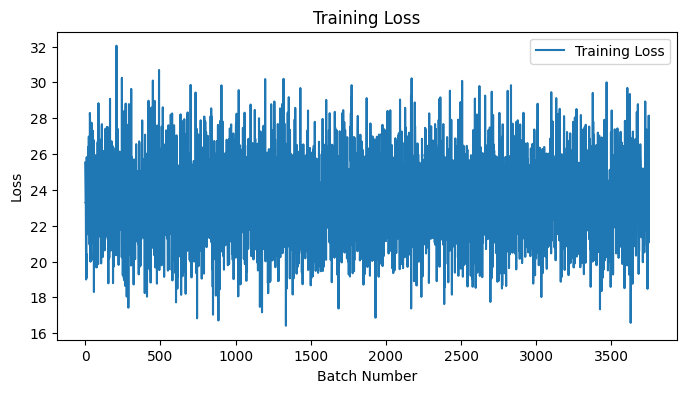

In [37]:
model = SimpleBitNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss()
num_epochs = 5

losses = []  # To store loss values

model.train()  # Set the model to training mode
for epoch in range(num_epochs):
    with tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as t:
        for batch_idx, (data, target) in t:
            optimizer.zero_grad()  # Zero the gradients
            output = model(data)  # Forward pass
            loss = criterion(output, target)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update parameters

            losses.append(loss.item())  # Append the loss

            # Optionally, update the tqdm bar with the current loss value
            t.set_postfix(loss=loss.item())

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
for name, param in model.named_parameters():
    if 'weight' in name:
        print(f"{name}: {param.data}")

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

# Calculate model size in MB
model_size = params * 4 / (1024 * 1024)  # Since each parameter is a 32-bit float, hence 4 bytes

print(f"Model size: {model_size:.2f} MB")

fc1.weight: tensor([[ 0.6073, -1.3968,  0.4151,  ..., -0.9675,  0.5284,  0.9772],
        [-1.9441,  0.0041, -0.0775,  ..., -0.1052,  0.1209,  2.0360],
        [ 0.8240,  0.4143, -1.4763,  ...,  0.6246,  0.4074,  0.4074],
        ...,
        [ 1.0206, -1.2960, -1.1027,  ...,  0.8934, -1.9012,  0.8208],
        [-0.0529, -1.4578,  0.6666,  ...,  0.5771,  1.4329, -0.9872],
        [-0.2740, -0.5562, -0.2417,  ...,  2.1472,  0.6066,  1.5957]])
fc2.weight: tensor([[-0.2327,  0.4354, -1.0200,  ..., -0.5488,  0.0220,  0.1474],
        [-1.4795,  0.9334, -2.0108,  ..., -0.4668,  0.5392,  1.2513],
        [ 0.2306, -0.4060, -0.7940,  ...,  0.0494,  0.2510,  2.0329],
        ...,
        [-1.6009,  0.9008, -0.2651,  ...,  0.6475, -0.0212, -1.5741],
        [-1.2545,  1.0603, -0.6187,  ...,  0.4521,  0.7964,  0.7586],
        [ 0.2543, -0.1092, -0.1625,  ...,  0.6757, -2.1447,  1.2021]])
Model size: 1.55 MB


In [14]:
true_labels, predictions  = predict(model, test_loader)

In [15]:
calculate_performance_metrics(true_labels, predictions )

Accuracy: 0.9333
Precision: 0.9350
Recall: 0.9326
F1 Score: 0.9327


In [2]:
import torch
from bitnet import BitLinear


In [3]:

# Input
x = torch.randn(10, 512)

# BitLinear layer
layer = BitLinear(512, 400)

# Output
y = layer(x)

print(y)

tensor([[-2.9149e+01,  3.3480e+01,  1.4276e+01,  ..., -2.8229e-01,
         -4.9277e+01, -5.2250e+00],
        [ 2.6004e+01,  2.3346e+01, -5.1196e+01,  ..., -5.1247e+01,
         -1.2943e+01,  1.7199e+01],
        [ 6.2679e+01,  1.3954e+01, -4.9143e+01,  ...,  4.8068e+01,
          3.7827e-02,  5.1727e+00],
        ...,
        [ 1.1154e+01,  5.6988e+01,  6.0008e+01,  ...,  4.8230e+00,
         -3.2385e+01,  1.8141e+01],
        [-5.4320e+00, -3.1057e+01, -2.4949e+01,  ..., -5.1860e+01,
         -1.5310e+01, -3.8016e+01],
        [ 5.4633e+01,  2.1161e+01, -2.9985e+01,  ...,  2.3603e+01,
          1.2187e+01, -9.6628e+00]], grad_fn=<CopyBackwards>)


In [5]:
layer.weight

Parameter containing:
tensor([[-0.0130, -0.0348,  0.0124,  ..., -0.0300,  0.0422,  0.0134],
        [-0.0053, -0.0135, -0.0339,  ...,  0.0200,  0.0087,  0.0032],
        [ 0.0369,  0.0210, -0.0267,  ..., -0.0426, -0.0151, -0.0254],
        ...,
        [ 0.0284, -0.0046, -0.0277,  ...,  0.0261, -0.0017, -0.0102],
        [ 0.0160, -0.0048,  0.0254,  ...,  0.0272,  0.0215,  0.0148],
        [-0.0418, -0.0432, -0.0032,  ...,  0.0012,  0.0309, -0.0149]],
       requires_grad=True)